In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from itertools import product

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Read in 
df10 = pd.read_csv('../data/df10.csv')

In [3]:
# Inspect
df10

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.611402,0.720283,3.165168,0.372100,-0.360194,6.417779,A2,B3,C16,D1,-16.680112
1,-0.463374,-0.908280,3.046919,0.866590,0.949304,6.142320,A1,B2,C6,D3,-0.347247
2,-0.004264,-2.710478,3.629876,0.587660,-0.413790,7.196720,A2,B1,C10,D3,-13.192616
3,0.310406,-0.511657,3.269785,3.036609,-0.430169,6.363889,A2,B5,C33,D2,0.764504
4,-2.537362,0.594968,1.731083,0.616347,1.753629,3.273066,A1,B1,C6,D3,1.757865
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.786519,-0.053336,4.551310,0.503011,-0.332187,8.955659,A2,B4,C48,D2,-5.785166
9996,-3.341972,-0.603921,2.693938,-0.788320,-0.766215,5.303121,A1,B5,C24,D2,19.692702
9997,-0.409354,0.337466,3.140098,-1.672133,-0.235241,5.997826,A1,B1,C32,D3,-0.011697
9998,-2.129938,-0.588379,3.735092,-0.368141,1.876631,7.281910,A2,B1,C16,D3,-17.691367


In [4]:
# Set random seed
np.random.seed(666)

# First attempt

- Ignore x9
- 60/20/20 train/test/holdout [6k/2k/2k rows]
- Within train, 6-fold cross-validation to optimize hyperparameters:
    - `max_depth` = 2-8
    - `max_features` = 'auto', 'sqrt', 'log2'
    - `subsample` = 0.5, 0.67, 0.75
    - Static parameters
        - `n_estimators` = 1k
        - `validation_fraction` = 0.2
        - `n_iter_no_change` = 1
        - `tol` = 1e-4
        
Also, will not include x3 and x6 because they were not found to have much relationship with y.

In [5]:
# Train/test/holdout vars
p_train = 0.6
p_test = 0.2
p_test_relative = p_test / (p_train + p_test)
p_holdout = 0.2
k_folds = 6

# Static hyperparameters
s_n_estimators = 1000
s_validation_fraction = 0.2
s_n_iter_no_change = 1
s_tol = 1e-4

# Lists of hyperparameters to optimize
l_max_depth = [2, 3, 4, 5, 6, 7, 8]
l_max_features = ['auto', 'sqrt', 'log2']
l_subsample = [0.5, 0.67, 0.75]

In [6]:
# Add some x2 predictors
df10['x2_abs'] = abs(df10['x2'])
df10['x2_sign'] = np.sign(df10['x2'])

# Create X/y
predictors_1 = ['x1', 'x2', 'x2_abs', 'x2_sign', 'x4', 'x5', 'x7', 'x8', 'x10']
X, y = pd.get_dummies(df10[predictors_1], prefix=['x7', 'x8', 'x10']), df10['y']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Check counts
print(f'''
Train: {X_train.shape}
Test: {X_test.shape}
Holdout: {X_holdout.shape}
''')


Train: (6000, 16)
Test: (2000, 16)
Holdout: (2000, 16)



In [7]:
# How many iterations of cross-validation?
hp_sets = list(product(l_max_depth, l_max_features, l_subsample))

len(hp_sets)

63

In [8]:
scores_1 = []
for md, mf, ss in hp_sets:
    # Print status
    print(f'Fitting max_depth={md}, max_features={mf}, subsample={ss}')
    
    # Initialize gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = md,
        max_features = mf,
        subsample = ss,
    )

    # Get scores
    cv_score = cross_val_score(
        gbm,
        X_train,
        y_train,
        cv = k_folds,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1
    ) 

    # Save the score means and standard deviations
    for i, k in enumerate(cv_score):
        scores_1 += [((md, mf, ss), i, k, np.mean(cv_score))]
    
    del gbm, cv_score

Fitting max_depth=2, max_features=auto, subsample=0.5
Fitting max_depth=2, max_features=auto, subsample=0.67
Fitting max_depth=2, max_features=auto, subsample=0.75
Fitting max_depth=2, max_features=sqrt, subsample=0.5
Fitting max_depth=2, max_features=sqrt, subsample=0.67
Fitting max_depth=2, max_features=sqrt, subsample=0.75
Fitting max_depth=2, max_features=log2, subsample=0.5
Fitting max_depth=2, max_features=log2, subsample=0.67
Fitting max_depth=2, max_features=log2, subsample=0.75
Fitting max_depth=3, max_features=auto, subsample=0.5
Fitting max_depth=3, max_features=auto, subsample=0.67
Fitting max_depth=3, max_features=auto, subsample=0.75
Fitting max_depth=3, max_features=sqrt, subsample=0.5
Fitting max_depth=3, max_features=sqrt, subsample=0.67
Fitting max_depth=3, max_features=sqrt, subsample=0.75
Fitting max_depth=3, max_features=log2, subsample=0.5
Fitting max_depth=3, max_features=log2, subsample=0.67
Fitting max_depth=3, max_features=log2, subsample=0.75
Fitting max_dept

In [9]:
# Save results as a dataframe
scores_1_df = pd.DataFrame(
    scores_1,
    columns = ['hp', 'k', 'score_k', 'score_hp_mean']
)

# Order by score_hp_mean and k
scores_1_df = scores_1_df.sort_values(['score_hp_mean', 'k'], ascending=[False, True]).reset_index()

scores_1_df.head(20)

,index,hp,k,score_k,score_hp_mean
0,66,"(3, auto, 0.75)",0,-57.627726,-61.303416
1,67,"(3, auto, 0.75)",1,-59.927675,-61.303416
2,68,"(3, auto, 0.75)",2,-62.608862,-61.303416
3,69,"(3, auto, 0.75)",3,-58.605912,-61.303416
4,70,"(3, auto, 0.75)",4,-64.853921,-61.303416
5,71,"(3, auto, 0.75)",5,-64.196400,-61.303416
6,108,"(4, auto, 0.5)",0,-59.429643,-61.668906
7,109,"(4, auto, 0.5)",1,-60.317286,-61.668906
8,110,"(4, auto, 0.5)",2,-63.072704,-61.668906
9,111,"(4, auto, 0.5)",3,-59.374377,-61.668906


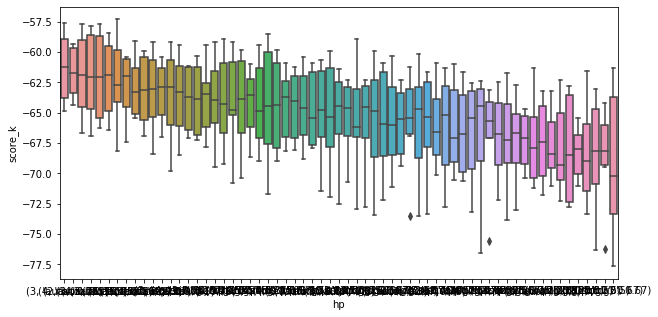

In [10]:
# Boxplot of performance for each parameter set
plt.figure(figsize=(10, 5))
sb.boxplot(
    data = scores_1_df,
    x = 'hp',
    y = 'score_k',
)

In [11]:
# Hyperparameter sets in order
scores_1_df.hp.unique()

array([(3, 'auto', 0.75), (4, 'auto', 0.5), (2, 'auto', 0.75),
       (3, 'auto', 0.5), (4, 'auto', 0.75), (3, 'auto', 0.67),
       (2, 'auto', 0.5), (2, 'auto', 0.67), (5, 'auto', 0.5),
       (5, 'auto', 0.75), (4, 'auto', 0.67), (5, 'auto', 0.67),
       (3, 'sqrt', 0.75), (6, 'auto', 0.5), (4, 'sqrt', 0.67),
       (6, 'auto', 0.75), (3, 'log2', 0.75), (5, 'sqrt', 0.75),
       (3, 'sqrt', 0.5), (4, 'log2', 0.75), (5, 'log2', 0.5),
       (4, 'log2', 0.5), (4, 'sqrt', 0.75), (5, 'sqrt', 0.67),
       (4, 'log2', 0.67), (4, 'sqrt', 0.5), (5, 'sqrt', 0.5),
       (6, 'auto', 0.67), (7, 'auto', 0.67), (5, 'log2', 0.67),
       (6, 'sqrt', 0.67), (7, 'auto', 0.5), (6, 'sqrt', 0.75),
       (3, 'sqrt', 0.67), (6, 'log2', 0.5), (3, 'log2', 0.67),
       (5, 'log2', 0.75), (8, 'auto', 0.5), (8, 'auto', 0.67),
       (6, 'log2', 0.67), (6, 'log2', 0.75), (7, 'auto', 0.75),
       (7, 'sqrt', 0.75), (2, 'sqrt', 0.75), (6, 'sqrt', 0.5),
       (7, 'sqrt', 0.67), (7, 'log2', 0.67), (3, 'log2

Quite a few of the unique combinations at the beginning are very similar and have rather similar distributional behavior in the boxplot.  In absense of a clear winner, let's proceed with the following parameter sets to provide some variety in models that may fit well on the test set.

- (3, 'auto', 0.75)  # Best overall performance
- (2, 'auto', 0.75)  # Best 2 depth performance
- (4, 'auto', 0.75)  # Best 4 depth performance
- (6, 'auto', 0.75)  # Best 6 depth performance
- (3, 'log2', 0.67)  # Best log2 performance
- (4, 'sqrt', 0.5)  # Best sqrt performance

In [12]:
# Fit new models on whole training data set
best_hp_sets = [
    (3, 'auto', 0.75),
    (2, 'auto', 0.75),
    (4, 'auto', 0.75),
    (6, 'auto', 0.75),
    (3, 'log2', 0.67),
    (4, 'sqrt', 0.5),
]
models_train_1 = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X_train, y_train)
    
    # Save predictions
    models_train_1[hp] = {
        'model': gbm,
        'train_err': y_train - gbm.predict(X_train),
        'test_err': y_test - gbm.predict(X_test)
    }
    
    del gbm

Fitting (3, 'auto', 0.75)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         188.3604          22.2521            6.99s
         2         161.1904          20.8613            6.99s
         3         154.5030          13.7389            6.98s
         4         135.3511          13.0265            6.97s
         5         127.4882           9.2971            6.77s
         6         119.7117           7.8903            6.79s
         7         110.5826           6.6609            6.67s
         8         106.7489           5.4957            6.70s
         9          99.3549           4.8446            6.72s
        10          95.2486           3.4564            6.63s
        20          75.4625           0.8525            6.32s
        30          65.4856           0.6876            6.21s
        40          60.5690           0.1650            6.14s
        50          57.9753           0.0975            6.04s
        60          55.8284           0.009

In [13]:
# Inspect one model
models_train_1[best_hp_sets[0]]

{'model': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=1, presort='deprecated',
                           random_state=None, subsample=0.75, tol=0.0001,
                           validation_fraction=0.2, verbose=1, warm_start=False),
 'train_err': 7820    10.064575
 5815     9.481590
 7309     0.469405
 7163     8.744251
 2674     5.849403
           ...    
 9907     3.154354
 485     11.788663
 264     -4.493576
 8577     9.022147
 6415    -5.346289
 Name: y, Length: 6000, dtype: float64,
 'test_err': 369      5.392732
 2608     7.546707
 2

In [14]:
# Compare average mean squared errors
def amse(err):
    return (err ** 2).sum() / len(err)

for hp in best_hp_sets:
    print(f'''{hp}
    Train error: {amse(models_train_1[hp]['train_err'])}
    Test error: {amse(models_train_1[hp]['test_err'])}
    ''')

(3, 'auto', 0.75)
    Train error: 56.49459523613887
    Test error: 61.93190010014272
    
(2, 'auto', 0.75)
    Train error: 58.611331821641905
    Test error: 61.902461369996615
    
(4, 'auto', 0.75)
    Train error: 55.859258527690834
    Test error: 62.16049740306054
    
(6, 'auto', 0.75)
    Train error: 48.48623107448711
    Test error: 62.81965300418269
    
(3, 'log2', 0.67)
    Train error: 60.72342809247705
    Test error: 64.8559763977514
    
(4, 'sqrt', 0.5)
    Train error: 56.48581236449429
    Test error: 64.09933074376158
    


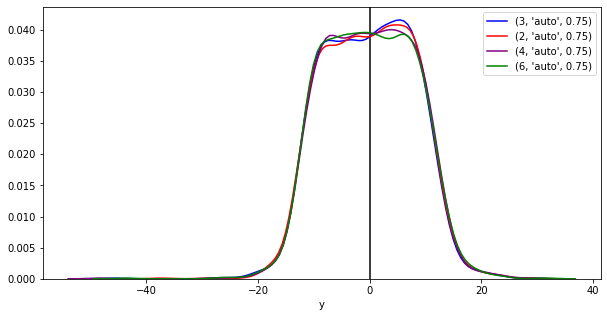

In [15]:
# Plot error distributions on test data for the better models
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
colors = ['blue', 'red', 'purple', 'green']
models_to_plot = best_hp_sets[:4]
for i, hp in enumerate(models_to_plot):
    sb.distplot(models_train_1[hp]['test_err'], hist=False, color=colors[i], label=hp)

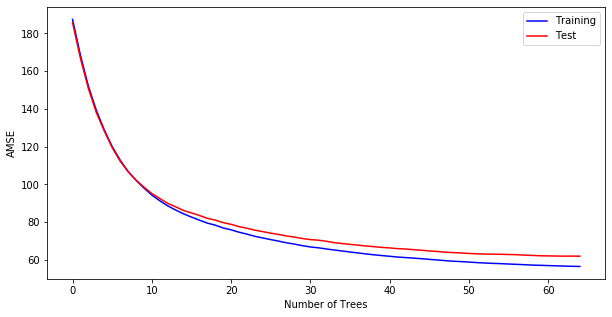

In [16]:
# Learning curves
def plot_lc(model):
    lc_train = [amse(y_train - x) for x in models_train_1[model]['model'].staged_predict(X_train)]
    lc_test = [amse(y_test - x) for x in models_train_1[model]['model'].staged_predict(X_test)]
    lc_x = list(range(len(lc_train)))

    plt.figure(figsize=(10, 5))
    sb.lineplot(x=lc_x, y=lc_train, color='blue', label='Training')
    sb.lineplot(x=lc_x, y=lc_test, color='red', label='Test')
    plt.xlabel('Number of Trees')
    plt.ylabel('AMSE')

# "Best" model
plot_lc(best_hp_sets[0])

All of the 'auto' models look similar on the test data but have rather different performance on the training data.

We'll gloss over that for now to see how x9 changes things.

# Now incorporate x9

x9 presents a unique problem with cross-validation.

Say we wanted to replace x9 with its group average.  If we use the averages over the **whole** training set, we introduce signal leakage in the folds being held out for test predictions (i.e. we're using the target variable in folds we're trying to predict to create predictors).  So if we really wanted to pair that with cross-validation to estimate hyperparameters we need to write custom code to derive that new `x9_group_mean` variable separately for each of the k iterations before fitting.  Which is possible but didn't want to go through that process here.

For simplicity, let's say we feel comfortable assuming that we only need to consider our current "best" sets of hyperparameters and evaluate using train/test splitting (i.e. use `hp_sets`).

In [17]:
# Get group means on training data
dict_x9_means = df10.groupby('x9').agg(y_mean=('y', 'mean'))['y_mean'].to_dict()
dict_x9_means

{'C0': -12.494134458422153,
 'C1': -8.868420283101097,
 'C10': -11.40502206758767,
 'C11': -7.0930213759957175,
 'C12': -2.447312707595968,
 'C13': 1.9692483054162397,
 'C14': 5.857638108593982,
 'C15': -12.786031256866941,
 'C16': -9.282874709668627,
 'C17': -3.4143419303076765,
 'C18': 1.169778150669182,
 'C19': 7.278886392506984,
 'C2': -2.541700718251264,
 'C20': -12.576496755315635,
 'C21': -8.977971508535472,
 'C22': -4.112889425340084,
 'C23': 2.2574156092691964,
 'C24': 6.581441556327919,
 'C25': -13.587177463212175,
 'C26': -8.756049305959065,
 'C27': -2.856583864898294,
 'C28': 1.222706607972358,
 'C29': 7.2578542985176,
 'C3': 2.6742546627484804,
 'C30': -13.36395689694065,
 'C31': -7.422958418992781,
 'C32': -2.713352221990513,
 'C33': 0.8747200195316601,
 'C34': 6.581315429600172,
 'C35': -13.935337569850585,
 'C36': -7.470498216195004,
 'C37': -2.662630707901458,
 'C38': 2.8610230402129915,
 'C39': 6.063442651636226,
 'C4': 6.3817031366626304,
 'C40': -14.930392835357917,

In [18]:
# Add some x2 predictors
df10['x9_group_mean'] = df10['x9'].map(dict_x9_means)

# Create X/y
predictors_2 = ['x1', 'x2', 'x2_abs', 'x2_sign', 'x4', 'x5', 'x7', 'x8', 'x9_group_mean', 'x10']
X, y = pd.get_dummies(df10[predictors_2], prefix=['x7', 'x8', 'x10']), df10['y']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Check counts
print(f'''
Train: {X_train.shape}
Test: {X_test.shape}
Holdout: {X_holdout.shape}
''')


Train: (6000, 17)
Test: (2000, 17)
Holdout: (2000, 17)



In [19]:
# Fit new models on whole training data set
models_train_2 = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X_train, y_train)
    
    # Save predictions
    models_train_2[hp] = {
        'model': gbm,
        'train_err': y_train - gbm.predict(X_train),
        'test_err': y_test - gbm.predict(X_test)
    }
    
    del gbm

Fitting (3, 'auto', 0.75)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         187.9581          27.4005            6.99s
         2         162.0351          22.8147            7.49s
         3         145.9342          18.2081            7.31s
         4         130.5333          15.5780            7.22s
         5         117.6847          12.5340            7.16s
         6         102.2628          11.5081            7.12s
         7          93.7548           8.7530            6.95s
         8          87.6549           6.5733            6.94s
         9          76.0242           6.9998            6.94s
        10          72.4431           5.4184            6.93s
        20          41.7191           1.5356            6.62s
        30          27.9049           1.0066            6.53s
        40          20.4169           0.5032            6.46s
        50          15.1939           0.4106            6.37s
        60          12.9171           0.198

In [20]:
# Compare average mean squared errors
for hp in best_hp_sets:
    print(f'''{hp}
    Train error: {amse(models_train_2[hp]['train_err'])}
    Test error: {amse(models_train_2[hp]['test_err'])}
    ''')

(3, 'auto', 0.75)
    Train error: 8.43567769019941
    Test error: 10.052377728974372
    
(2, 'auto', 0.75)
    Train error: 9.876156960509979
    Test error: 11.637296279992828
    
(4, 'auto', 0.75)
    Train error: 6.806489000392832
    Test error: 9.674668463289482
    
(6, 'auto', 0.75)
    Train error: 6.365590104509967
    Test error: 12.81593049569236
    
(3, 'log2', 0.67)
    Train error: 9.995045856377114
    Test error: 12.853638742869578
    
(4, 'sqrt', 0.5)
    Train error: 8.689096255503364
    Test error: 11.707616908485845
    


Best fit on test seems to be (3, 'auto', 0.75), even though it doesn't have the lowest training error.

My initial suspicion is that the training error is low on (6, 'auto', 0.75) due to overfitting on the training data.  Probably because we aren't using any type of tree regularization (e.g. pruning, requiring a certain sample size) to simplify the trees that get built.

### Plot univariates to see if any other sort of modification might improve model fit

In [21]:
def plot_univariate(df, x, y, filter_x7=None, model_fit=models_train_2[best_hp_sets[0]], n_bins=10):
    # Create copy of dataframe
    df = df.copy()
    
    # Subset to test rows
    df = df.iloc[X_test.index]
    
    # Add prediction
    df = df.assign(p = model_fit['model'].predict(X_test))
    
    # Apply filter_x7
    if filter_x7:
        df = df[df10.x7 == filter_x7]
    
    # If x is numeric, bin into groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], n_bins).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            y_sd=(y, 'std'),
            p_mean=('p', 'mean'),
            p_sd=('p', 'std'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    ax2.errorbar(x, 'y_mean', yerr='y_sd', data=df_agg, label='Actual', fmt='o', capsize=10, color='green')
    ax2.errorbar(x, 'p_mean', yerr='p_sd', data=df_agg, label='Predicted', fmt='o', capsize=10, color='red')
    
    plt.legend()
    plt.show()

                 x1    n     y_mean       y_sd    p_mean       p_sd
0  (-3.349, -2.656]   14 -10.483115  15.085686 -9.510717  14.407930
1  (-2.656, -1.971]   40  -5.783603  12.650469 -5.380929  11.651589
2  (-1.971, -1.285]  121  -4.694796  14.911796 -4.724729  14.056119
3  (-1.285, -0.599]  361  -2.241680  14.686556 -2.187700  13.747346
4  (-0.599, 0.0864]  531  -0.921520  14.677675 -1.508798  14.043787
5   (0.0864, 0.772]  479  -5.907316  13.252324 -5.781188  12.112404
6    (0.772, 1.458]  303  -5.421904  15.098284 -5.153293  13.898052
7    (1.458, 2.143]  114  -4.513584  13.897776 -4.342896  13.233334
8    (2.143, 2.829]   32  -3.624521  13.091653 -3.148676  12.491858
9    (2.829, 3.515]    5   3.827210  15.228232  3.995983  14.906523


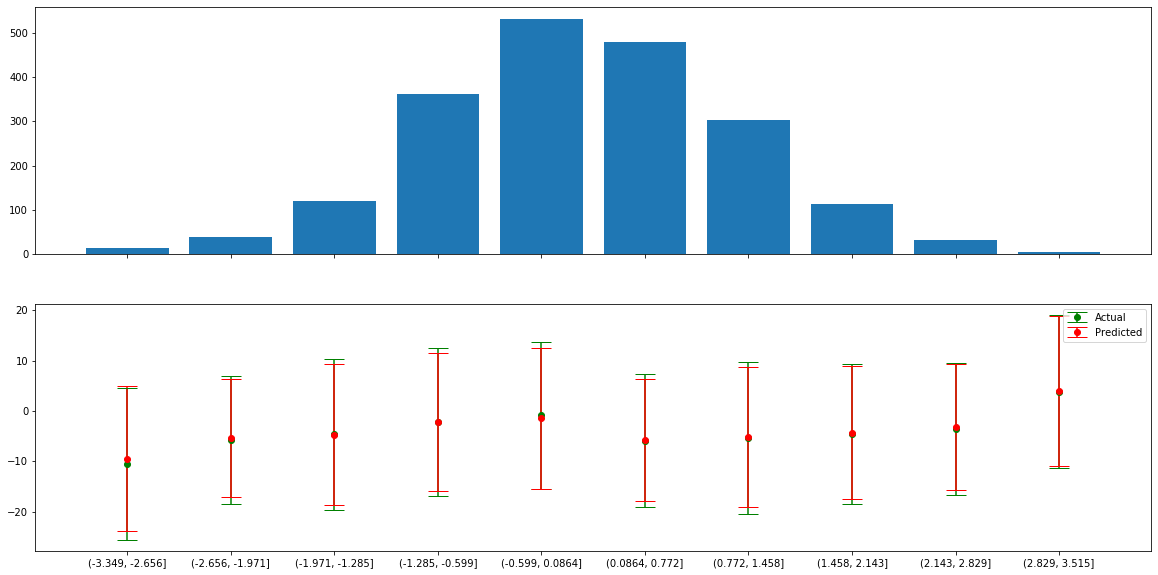

In [22]:
# x1
plot_univariate(df10, 'x1', 'y')

                 x2    n    y_mean       y_sd    p_mean       p_sd
0  (-3.279, -2.595]   11 -8.963161   8.915807 -8.734094   9.011515
1  (-2.595, -1.917]   51 -2.583432   9.656766 -2.919649   9.659528
2   (-1.917, -1.24]  148 -3.944287  12.748935 -3.991694  12.741910
3   (-1.24, -0.562]  324 -3.311579  16.481169 -3.135562  14.884601
4   (-0.562, 0.115]  516 -3.096149  15.152012 -3.223300  14.060587
5    (0.115, 0.793]  502 -4.007994  14.113056 -4.034378  13.152031
6    (0.793, 1.471]  308 -3.565381  13.985441 -3.603311  13.291714
7    (1.471, 2.148]  105 -6.141877  13.036458 -6.328298  12.592703
8    (2.148, 2.826]   29 -4.510177   8.878486 -4.957544   9.259542
9    (2.826, 3.503]    6  6.986870  13.642510  6.782526  13.087768


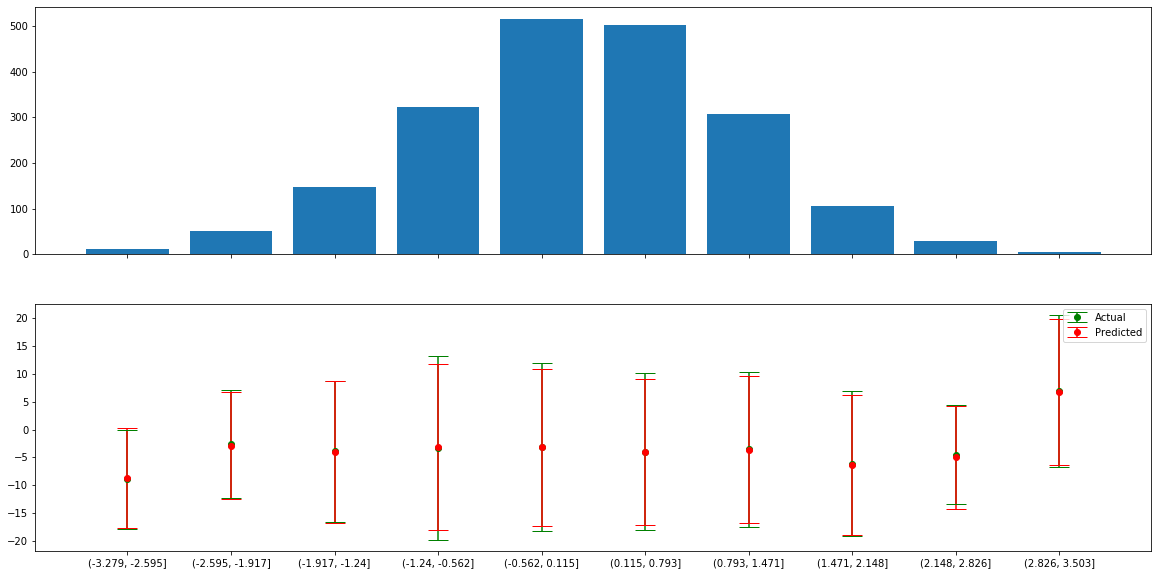

In [23]:
# x2
plot_univariate(df10, 'x2', 'y')

<ipython-input-21-aae3c8e7af56>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df10.x7 == filter_x7]


                 x2    n    y_mean       y_sd    p_mean       p_sd
0  (-3.271, -2.591]    5 -8.106606   8.415644 -5.958949   7.850367
1  (-2.591, -1.917]   24 -0.454520  10.475494  0.642160  10.326510
2  (-1.917, -1.243]   66  5.468557   9.691468  6.128608   9.324274
3  (-1.243, -0.569]  143  7.990921  12.138608  7.690669  10.142286
4   (-0.569, 0.105]  245  7.707951  12.060639  6.875480  11.036854
5    (0.105, 0.778]  226  7.482381   9.601512  6.605430   9.143906
6    (0.778, 1.452]  157  5.186901  10.571099  4.969269   9.709139
7    (1.452, 2.126]   53  2.455858  10.313153  2.483378   9.699326
8      (2.126, 2.8]    9 -5.622920   6.225904 -3.758338   6.917436
9      (2.8, 3.474]    3  4.351880  11.060596  6.493901  11.556198


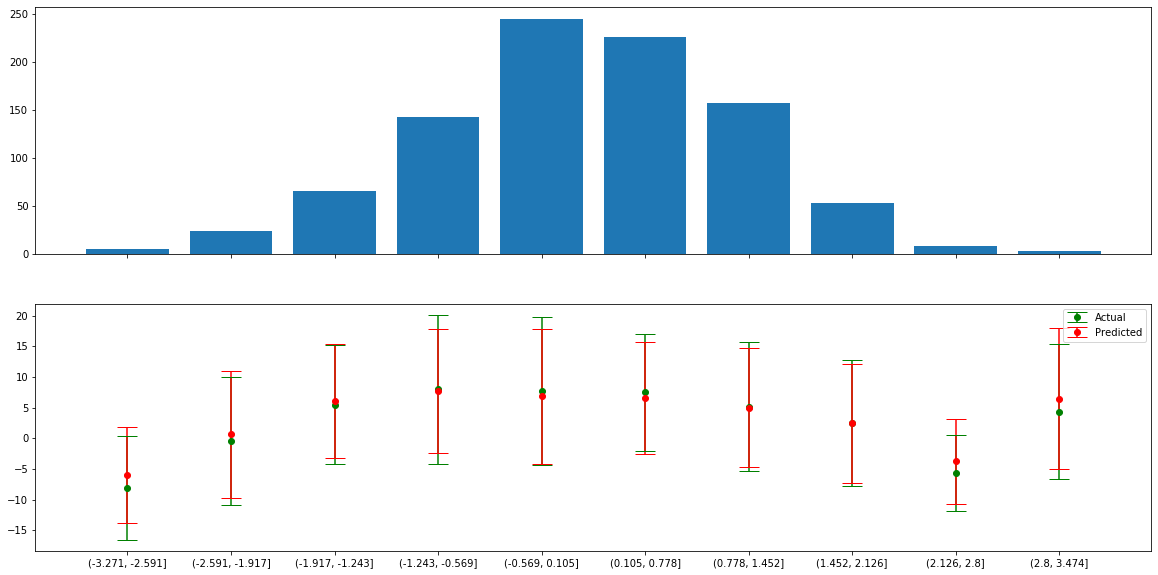

In [24]:
# x2 * x7 == A1
plot_univariate(df10, 'x2', 'y', filter_x7='A1')

<ipython-input-21-aae3c8e7af56>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df10.x7 == filter_x7]


                 x2    n     y_mean       y_sd     p_mean       p_sd
0  (-3.279, -2.595]    6  -9.676958  10.048865 -11.046714   9.949519
1  (-2.595, -1.917]   27  -4.475799   8.623015  -6.085701   7.936182
2   (-1.917, -1.24]   82 -11.520478   9.449803 -12.137302   8.617098
3   (-1.24, -0.562]  178 -12.621042  13.489726 -12.040136  11.967164
4   (-0.562, 0.115]  269 -13.150621   9.761618 -12.642806   8.984183
5    (0.115, 0.793]  279 -12.984273  10.235272 -12.326598   9.576456
6    (0.793, 1.471]  148 -13.208319  10.359310 -13.043950   9.718313
7    (1.471, 2.148]   57 -12.820662  11.315906 -13.226123  10.470990
8    (2.148, 2.826]   20  -4.009443   9.949655  -5.497187  10.257528
9    (2.826, 3.503]    3   9.621860  17.947949   7.071151  17.158920


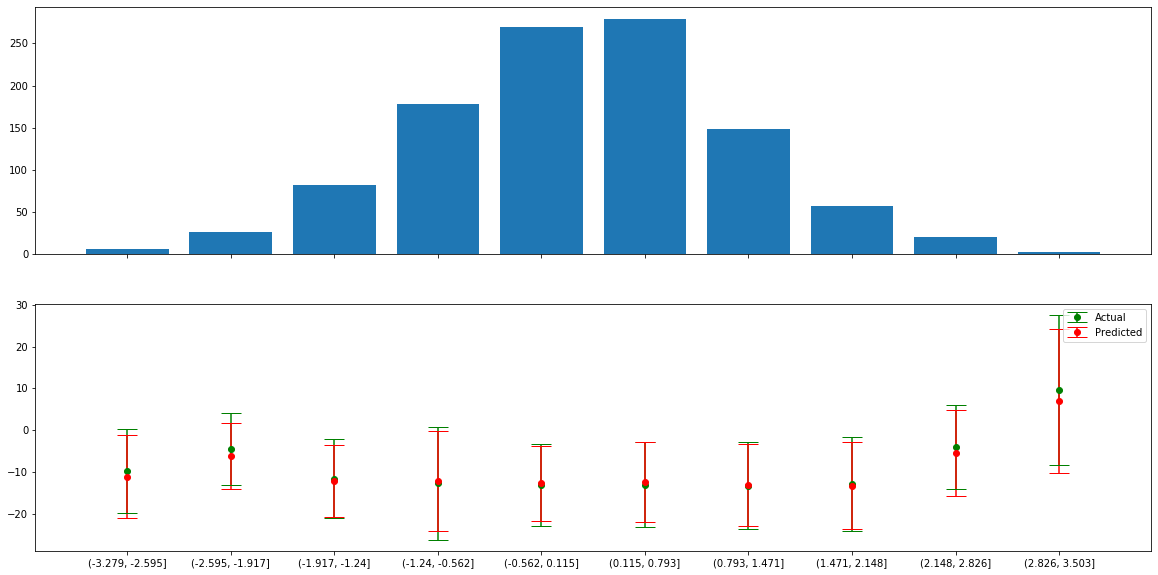

In [25]:
# x2 * x7 == A2
plot_univariate(df10, 'x2', 'y', filter_x7='A2')

                x3    n     y_mean       y_sd     p_mean       p_sd
0  (-0.323, 0.366]    9 -11.805981  10.815292 -10.278215  10.863236
1   (0.366, 1.048]   43  -0.902139  16.096326  -1.548146  15.389083
2    (1.048, 1.73]  165  -4.245541  13.734647  -4.383280  13.269816
3    (1.73, 2.412]  362  -2.600431  14.504536  -2.618939  13.311155
4   (2.412, 3.094]  530  -4.319000  14.038637  -4.155125  13.170908
5   (3.094, 3.776]  462  -3.946593  14.129089  -4.076109  13.425011
6   (3.776, 4.458]  288  -2.848500  15.211305  -3.084338  13.932984
7    (4.458, 5.14]  113  -3.893005  16.089874  -4.105210  14.911028
8    (5.14, 5.822]   25  -5.653557  14.065525  -4.966070  12.868131
9   (5.822, 6.504]    3  -9.220591  19.771726  -8.478534  19.004404


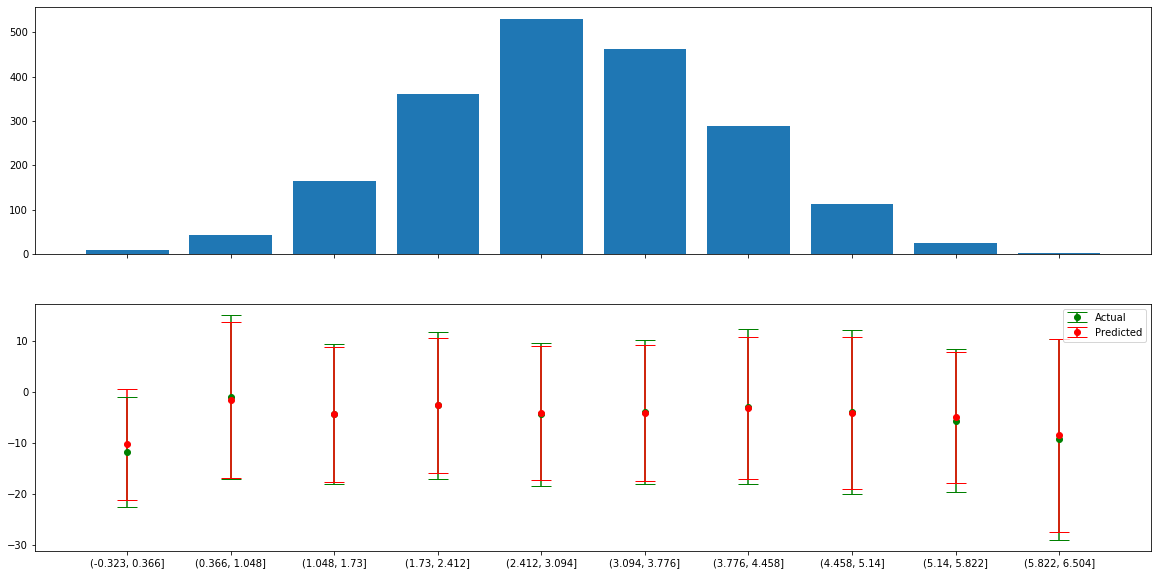

In [26]:
# x3
plot_univariate(df10, 'x3', 'y')

                 x4    n     y_mean       y_sd     p_mean       p_sd
0  (-3.336, -2.646]    6 -10.930331  12.006297 -11.385210  12.616869
1  (-2.646, -1.964]   37  -5.186150  19.615593  -4.916030  18.798011
2  (-1.964, -1.281]  136  -6.879913  13.236798  -6.676412  12.625012
3  (-1.281, -0.598]  358  -5.059908  15.377327  -4.888964  14.452030
4  (-0.598, 0.0847]  511  -4.743645  13.660591  -4.700007  12.697987
5   (0.0847, 0.767]  508  -2.253742  14.386944  -2.455780  13.306980
6     (0.767, 1.45]  305  -1.745711  14.430397  -1.653970  13.463185
7     (1.45, 2.133]  108  -1.684101  13.362159  -2.528564  12.830407
8    (2.133, 2.816]   23  -0.794036  15.371043  -1.594619  14.407141
9    (2.816, 3.499]    8  -2.814282  15.805801  -5.701012  14.801207


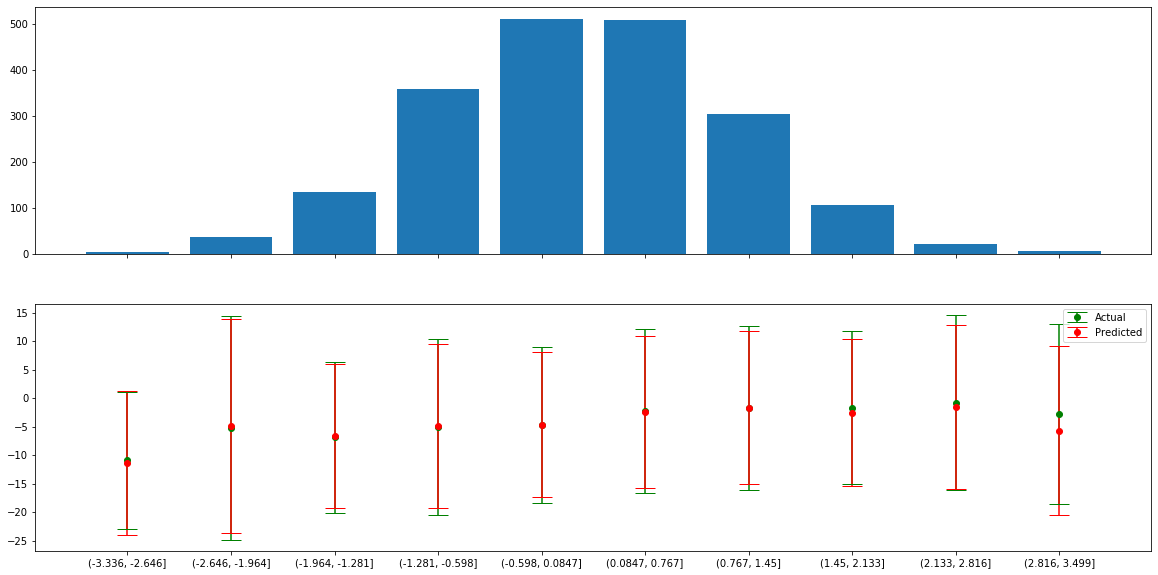

In [27]:
# x4
plot_univariate(df10, 'x4', 'y')

                 x5    n     y_mean       y_sd     p_mean       p_sd
0  (-3.852, -3.123]    2 -50.635420  13.284488 -29.766208  10.681744
1  (-3.123, -2.402]   19 -17.244148  13.685882 -17.033211  12.357699
2   (-2.402, -1.68]   89  -4.393372  12.563297  -4.130618  12.023744
3   (-1.68, -0.958]  215   0.895493  12.860241  -0.082782  11.845651
4  (-0.958, -0.236]  502  -2.165445  13.036187  -2.304168  12.284462
5   (-0.236, 0.486]  558  -6.025738  13.261995  -5.978972  12.592389
6    (0.486, 1.207]  394  -7.183013  13.656944  -6.808845  12.866280
7    (1.207, 1.929]  177  -1.962756  15.046731  -2.142035  14.084259
8    (1.929, 2.651]   36  14.132880  15.216990  15.327285  13.422852
9    (2.651, 3.373]    8  52.118193  18.582697  44.259100  18.781914


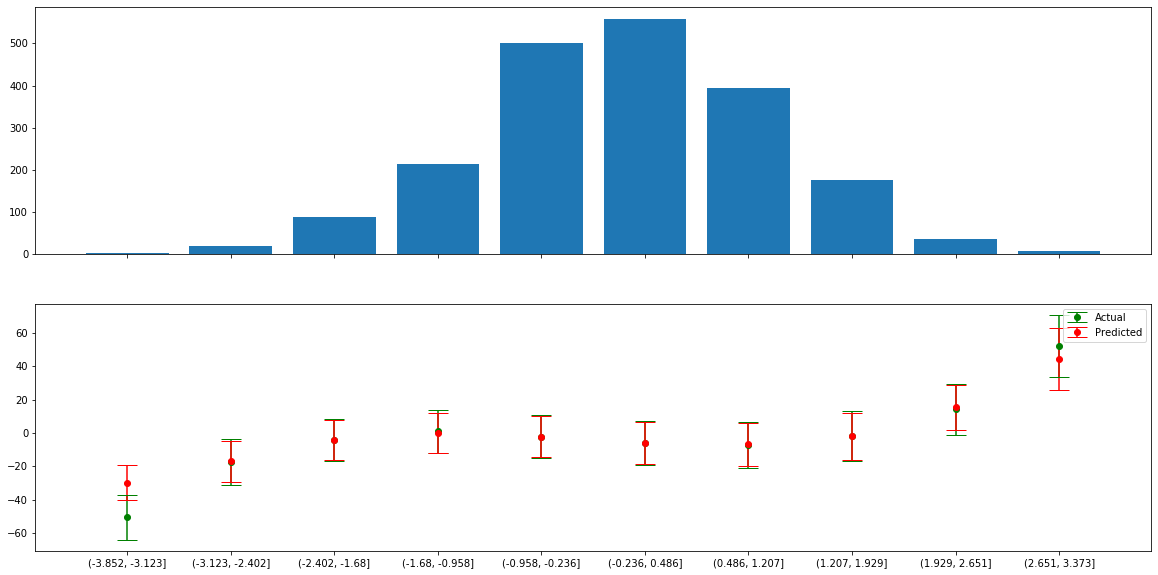

In [28]:
# x5
plot_univariate(df10, 'x5', 'y')

                 x6    n     y_mean       y_sd     p_mean       p_sd
0   (-0.968, 0.459]    6 -14.542230   4.385183 -12.090140   6.284623
1    (0.459, 1.871]   34   1.585852  15.082694   0.895465  14.378587
2    (1.871, 3.284]  146  -4.745006  14.198404  -5.068334  13.758216
3    (3.284, 4.697]  358  -3.081514  14.421713  -3.029135  13.348786
4    (4.697, 6.109]  523  -3.785036  14.272484  -3.735717  13.281872
5    (6.109, 7.522]  494  -4.211936  13.714992  -4.155728  13.045657
6    (7.522, 8.934]  298  -3.055536  15.420581  -3.382481  14.176841
7   (8.934, 10.347]  114  -3.306535  16.295409  -3.521050  15.087780
8  (10.347, 11.759]   24  -5.302985  13.386852  -4.649392  12.243378
9  (11.759, 13.172]    3  -8.088833  18.924234  -7.779642  18.505716


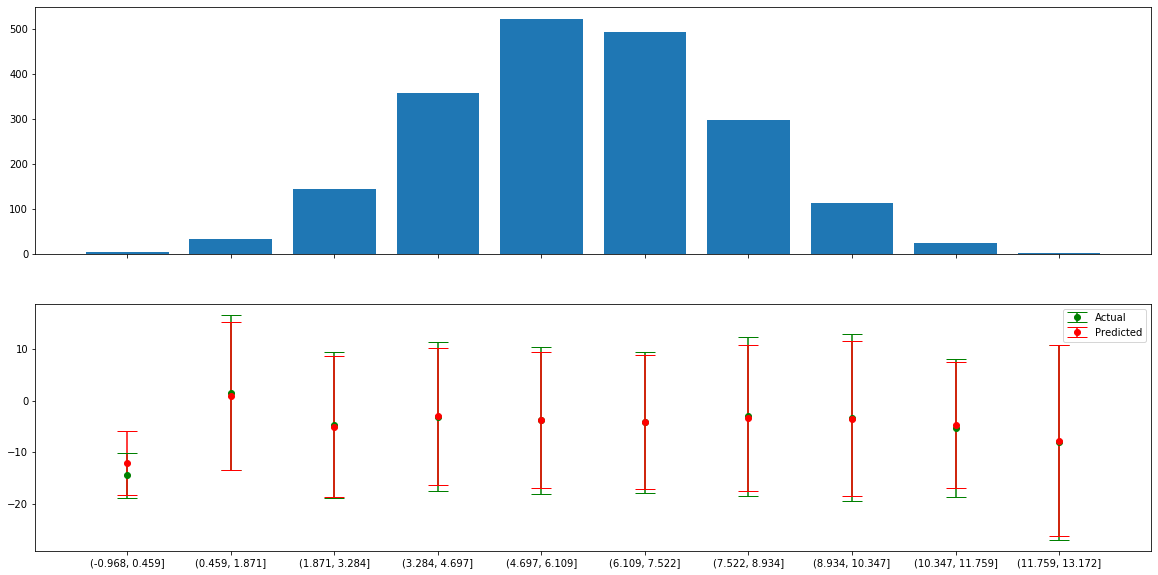

In [29]:
# x6
plot_univariate(df10, 'x6', 'y')

   x7     n     y_mean       y_sd     p_mean       p_sd
0  A1   931   6.378737  11.131655   5.977058  10.133709
1  A2  1069 -12.410846  10.906534 -12.144206   9.985393


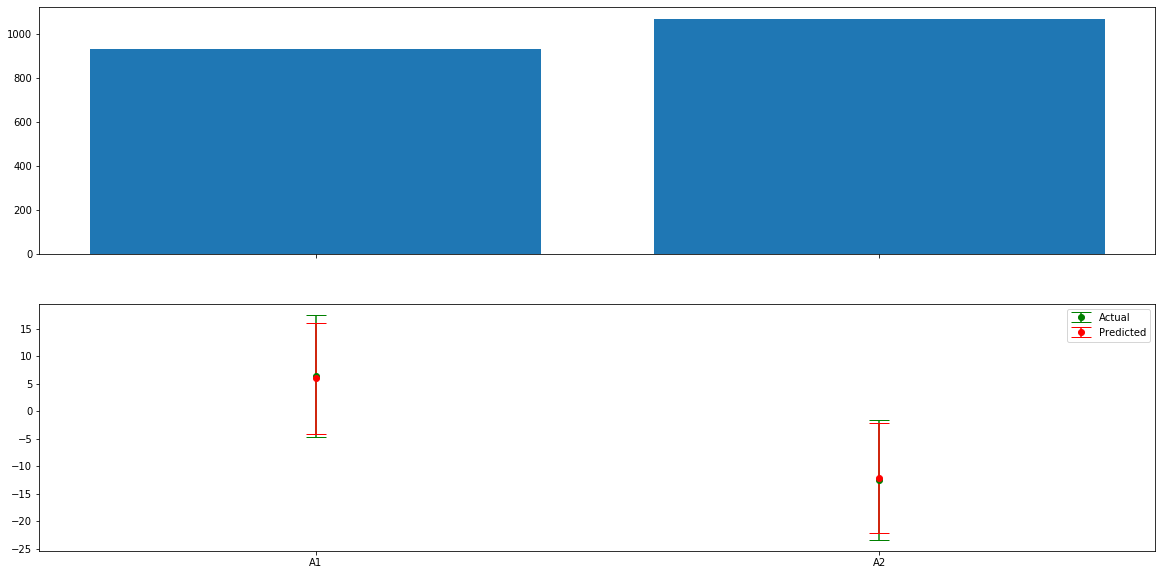

In [30]:
# x7
plot_univariate(df10, 'x7', 'y')

   x8    n    y_mean       y_sd    p_mean       p_sd
0  B1  408 -9.870796  14.827481 -9.653565  13.941165
1  B2  384 -9.155140  13.449646 -8.953264  12.357008
2  B3  439  0.319236  13.723353  0.079545  12.639270
3  B4  365 -0.198614  13.249155 -0.295700  12.409125
4  B5  404  0.362915  12.953490  0.079710  12.248614


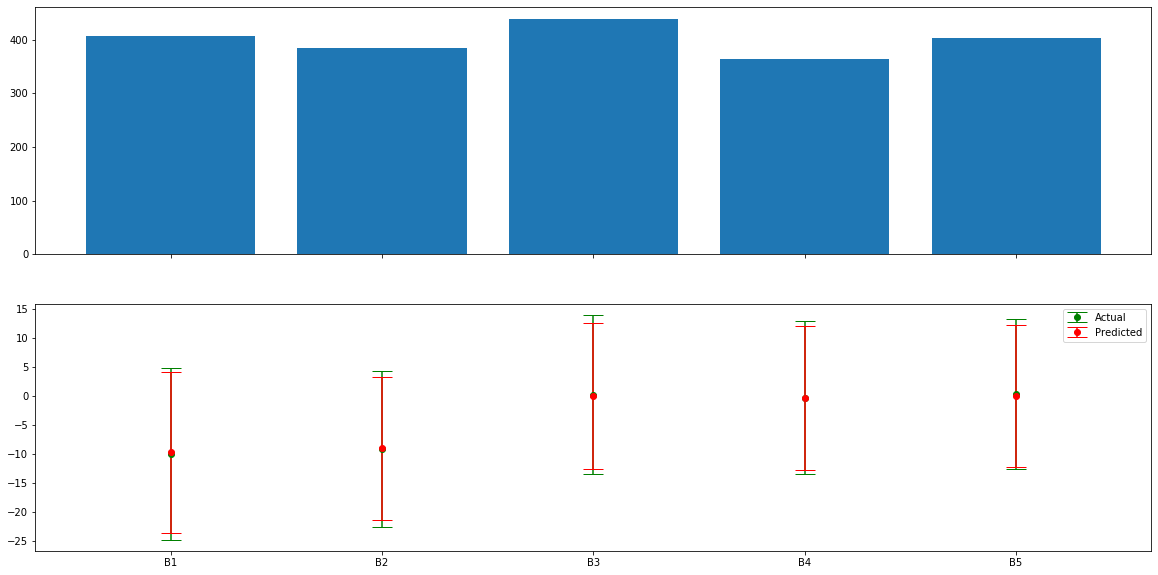

In [31]:
# x8
plot_univariate(df10, 'x8', 'y')

     x9   n     y_mean       y_sd     p_mean       p_sd
0    C0  44 -11.449154  11.865423 -12.427673  11.109242
1    C1  39  -7.403877  11.560906  -8.267946  10.157899
2   C10  41  -8.399086  15.627309  -8.127629  13.539616
3   C11  41  -8.086080  12.148196  -8.078684  11.405305
4   C12  42  -8.241409  12.543559  -7.497930  11.977384
5   C13  48  -2.180046  14.542123  -1.155110  11.987522
6   C14  44   3.727839  12.759579   3.370165  11.804630
7   C15  43 -12.738585  11.075329 -12.668696  10.187880
8   C16  47  -9.826713  11.958178 -10.435125  10.206881
9   C17  47  -3.939025  12.629985  -4.896842  11.858925
10  C18  51  -3.557728  10.818493  -3.049462  10.463079
11  C19  35   7.096602  12.006954   6.909548  11.255236
12   C2  34  -2.137282  12.039587  -1.910870  11.751000
13  C20  40 -11.236139  12.753242 -11.584592  12.385571
14  C21  34  -7.729983  14.700335  -7.910607  13.103456
15  C22  30  -8.004749  11.753302  -8.777383  11.082512
16  C23  25  -1.158287  11.773694  -1.385416  10

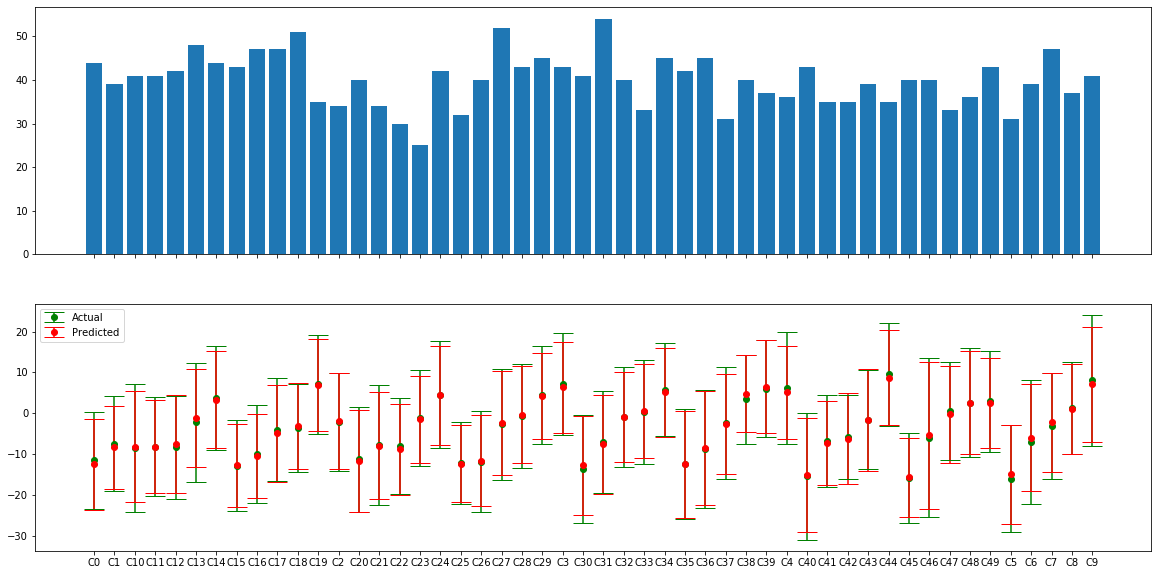

In [32]:
# x9
plot_univariate(df10, 'x9', 'y')

  x10    n    y_mean       y_sd    p_mean       p_sd
0  D1  421  0.256379  13.741910  0.012459  12.661584
1  D2  826 -0.427810  13.260177 -0.484752  12.414018
2  D3  753 -9.406580  14.293531 -9.325837  13.286679


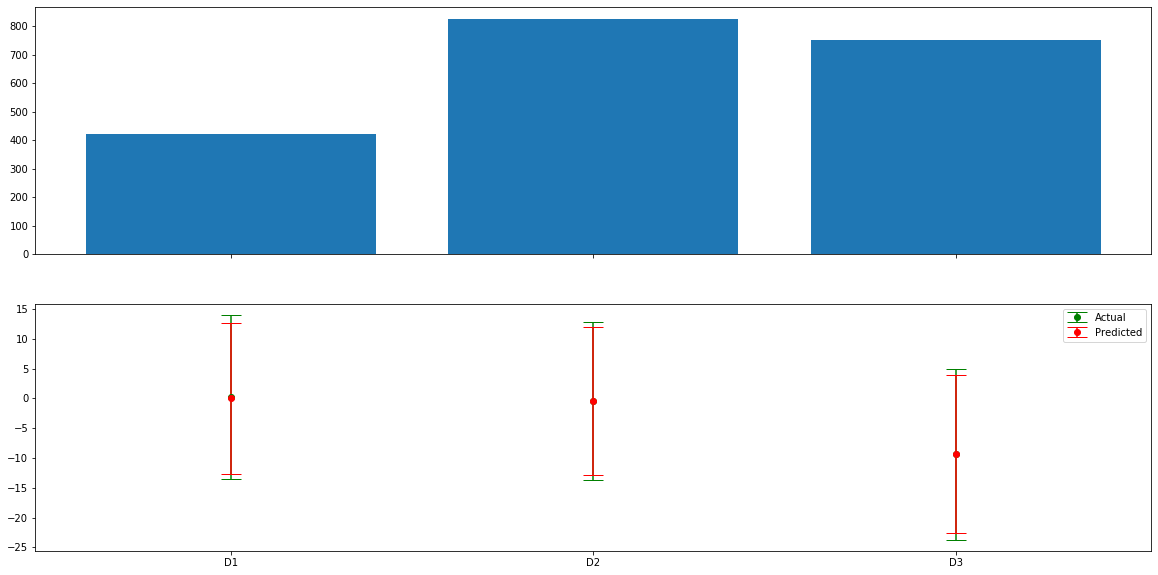

In [33]:
# x10
plot_univariate(df10, 'x10', 'y')

The only thing that really sticks out is relatively extreme x5 values, but we'd be affected ~10 rows by doing anything.  So let's leave the model as is.

# Evaluate on holdout

Let's evaluate all of our "best" hyperparameter sets to see how the holdout results compare to train/test results.

In [34]:
# Refit models on train and test data together
models_traintest = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Get train+test data
    X = X_train.append(X_test)
    y = y_train.append(y_test)
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X, y)
    
    # Save predictions
    models_traintest[hp] = {
        'model': gbm,
        'err': y - gbm.predict(X),
        'holdout_err': y_holdout - gbm.predict(X_holdout)
    }
    
    del X, y, gbm

Fitting (3, 'auto', 0.75)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         181.9605          27.9692            9.99s
         2         158.9520          24.3891            9.48s
         3         139.8914          19.6705            9.31s
         4         123.1233          15.8773            9.21s
         5         113.5691          12.4695            9.15s
         6         101.0095          10.2946            9.11s
         7          93.0842           8.0580            9.08s
         8          86.3467           7.2767            9.05s
         9          78.3931           6.1870            9.03s
        10          71.7174           5.7051            9.01s
        20          42.2979           1.8025            8.77s
        30          28.6646           0.7914            8.70s
        40          20.7990           0.4890            8.59s
        50          15.6994           0.2840            8.49s
        60          13.0586           0.120

In [35]:
# Create df of train, test, train+test, and holdout performance for each best hyperparameter space
all_performance = dict()
for hp in best_hp_sets:
    all_performance[hp] = [
        amse(models_train_2[hp]['train_err']),
        amse(models_train_2[hp]['test_err']),
        amse(models_traintest[hp]['err']),
        amse(models_traintest[hp]['holdout_err']),
    ]
    
all_performance_df = pd.DataFrame.from_dict(
    all_performance,
    orient='index',
    columns=['train', 'test', 'train+test', 'holdout']
).reset_index()

all_performance_df

,index,train,test,train+test,holdout
0,"(3, auto, 0.75)",8.435678,10.052378,7.715626,10.085879
1,"(2, auto, 0.75)",9.876157,11.637296,8.908505,11.306184
2,"(4, auto, 0.75)",6.806489,9.674668,7.156174,11.235317
3,"(6, auto, 0.75)",6.365590,12.815930,6.558474,11.561278
4,"(3, log2, 0.67)",9.995046,12.853639,9.786752,12.756255
5,"(4, sqrt, 0.5)",8.689096,11.707617,8.612362,12.685475


In [36]:
# Melt for proper group bargraphing
all_performance_df_melt = pd.melt(all_performance_df, id_vars='index')

all_performance_df_melt

,index,variable,value
0,"(3, auto, 0.75)",train,8.435678
1,"(2, auto, 0.75)",train,9.876157
2,"(4, auto, 0.75)",train,6.806489
3,"(6, auto, 0.75)",train,6.365590
4,"(3, log2, 0.67)",train,9.995046
5,"(4, sqrt, 0.5)",train,8.689096
6,"(3, auto, 0.75)",test,10.052378
7,"(2, auto, 0.75)",test,11.637296
8,"(4, auto, 0.75)",test,9.674668
9,"(6, auto, 0.75)",test,12.815930


Text(0, 0.5, 'AMSE')

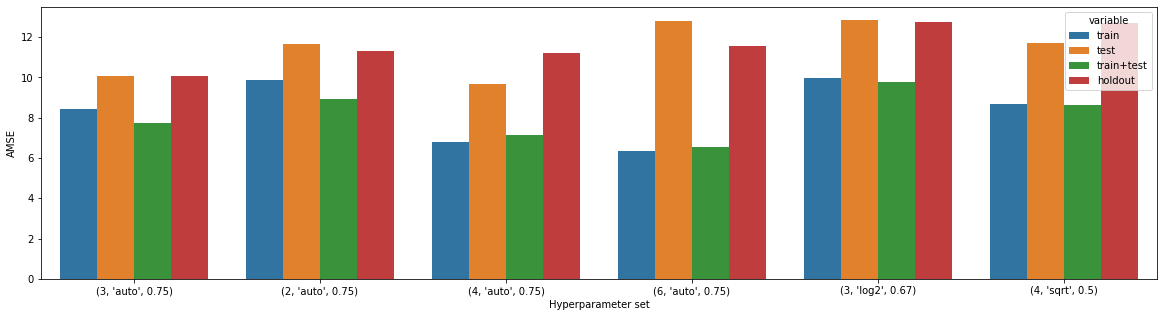

In [37]:
# Plot
plt.figure(figsize=(20, 5))
sb.barplot(
    data=all_performance_df_melt,
    x='index',
    y='value',
    hue='variable',
)
plt.xlabel('Hyperparameter set')
plt.ylabel('AMSE')

Text(0, 0.5, 'AMSE')

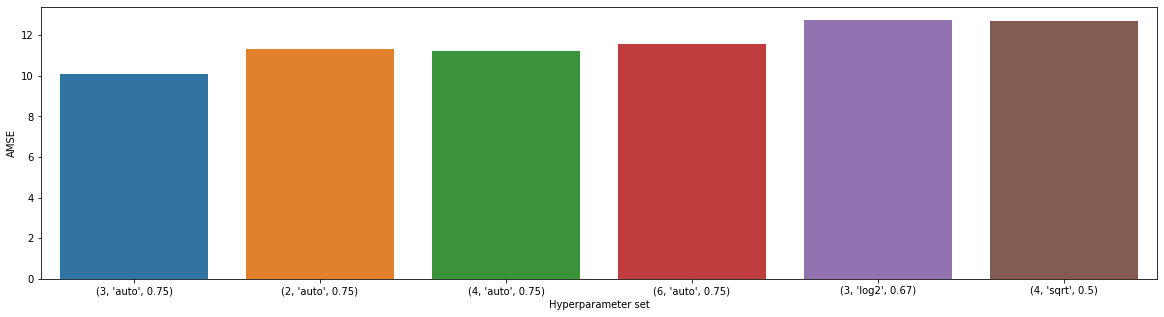

In [38]:
# Plot just holdout performance
plt.figure(figsize=(20, 5))
sb.barplot(
    data=all_performance_df_melt[all_performance_df_melt.variable == 'holdout'],
    x='index',
    y='value',
)
plt.xlabel('Hyperparameter set')
plt.ylabel('AMSE')

(3, auto, 0.75) seems like the best all-around fit:

- Second best performance on the test data and best performance on the holdout data
    - There's a lot of room for muddiness in picking between models that seem to be performing similarly, so "average" performance across test/holdout is something I usually use in making final decisions on which model to use
    - But, sometimes, the best thing to do is run multiple models in parallel in a "staging" type setup to see how they perform on new data and then make a final decision
- Similar performance on holdout set compared to test set
    - I generally index highly on having similar result in test/holdout unless there is a good reason for them to be different

Some other notes:

- (4, auto, 0.75) and (6, 'auto', 0.75) had the best performances on train-only and train/test-only data but worse performance on test and holdout (i.e. overfitting!)
    - As stated previously in the notebook, this is likely due to not having any sort of regularization (e.g. pruning, requiring a certain sample size) to balance tree complexity with accuracy
- The 'sqrt' and 'log' models don't do as well (they usually do right out of the box)
    - This is likely due to us restricting to only strong predictors at the outset, so when we sample those predictors we are excluding information that would likely be helpful